In [1]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt
from matplotlib import cm 
import numpy as np


In [2]:
def shell_do(command, log=False, return_log=False):
    print(f'Executing: {(" ").join(command.split())}', file=sys.stderr)

    res=subprocess.run(command.split(), stdout=subprocess.PIPE)

    if log:
        print(res.stdout.decode('utf-8'))
    if return_log:
        return(res.stdout.decode('utf-8'))

In [3]:
ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
ashk_data = f'/data/LNG/iwakih2/dataset/Jew/GSE23636'
onekg_demog_path = f'{ref_dir_path}/igsr_samples.tsv'
out_ancestry_file = f'{ref_dir_path}/ref_panel_ancestry.txt'
ref_panel = f'{ref_dir_path}/1kg_ashkj_ref_panel'

In [4]:
# first, create list of Ashkenazis by FID and IID
ashk = pd.read_csv(f'{ashk_data}.fam', header=None, sep=' ')

# add ashkenazis with labels to df
ancestry = pd.DataFrame()
ancestry[['FID','IID']], ancestry['label'] = ashk[[0,1]], 'AJ'


In [8]:
# read 1kG and label 
onekg_demog = pd.read_csv(onekg_demog_path, sep='\t')
onekg_demog['FID'], onekg_demog['IID'] = onekg_demog['Sample name'], onekg_demog['Sample name']
onekg_demog['label'] = onekg_demog['Superpopulation code']

# create separate label for African American (ASW) and Caribbean (ACB) label to AAC to match Neuro+
onekg_demog.loc[(onekg_demog['Population code'] == 'ASW') | (onekg_demog['Population code'] == 'ACB'), 'label'] = 'AAC'

# create separate label for Finnish (FIN) to match Neuro+
onekg_demog.loc[onekg_demog['Population code'] == 'FIN', 'label'] = 'FIN'
onekg_demog.label.unique()
ref_fam = pd.read_csv(f'{ref_panel}.fam', header=None, sep=' ')
ref_fam.rename(columns={0:'FID',1:'IID'}, inplace=True)
onekg_demog = ref_fam.merge(onekg_demog, how='left', on=['FID','IID'])


In [9]:
# check if all populations in GP2 are present Add Ashkenazi (AJ)
#figure out the situation with CHD
pop_dict = {
    'AMR': ['MXL','CLM','PEL','PUR'],
    'EAS': ['JPT','CDX','CHB','CHS','KHV','CHD'],
    'EUR': ['TSI','IBS','GBR','CEU', 'AJ', 'FIN'],
    'SAS': ['PJL','ITU','STU','GIH','BEB'],
    'AFR': ['GWD','MSL','ESN','GWJ','YRI','LWK','GWF','GWW'],
    'AAC': ['ASW','ACB']
}

pop_list = [pop for poplist in [pop for supergroup, pop in pop_dict.items()] for pop in poplist]

print('Counts per population code in 1kG')
total = 0
for pop in pop_list:
    count = (onekg_demog['Population code'] == pop).sum()
    print(pop, count)
    total += count
    
print(f'Total across population codes in 1kG: {total}')
print()
# keep only onekg_demog populations that are in population list (pops in neuro+ chip, given by GP2)
onekg_demog = onekg_demog.loc[onekg_demog['Population code'].isin(pop_list)]

#append onekg_demog to ancestry
ancestry_final = ancestry.append(onekg_demog[['FID','IID','label']], ignore_index=True)
ancestry_final.to_csv(out_ancestry_file, header=False, index=False, sep='\t')
ancestry_final[['FID','IID']].to_csv(f'{ref_dir_path}/gp2_keep.txt', sep='\t', header=None, index=None)
print()
print('Counts per superpopulation code in 1kG + Ashkenazi')
print(ancestry_final.label.value_counts(dropna=False))
print(f'Total across superpopulation codes in 1kG + Ashkenazi: {ancestry_final.label.value_counts(dropna=False).sum()}')

Counts per population code in 1kG
MXL 64
CLM 94
PEL 85
PUR 104
JPT 104
CDX 93
CHB 103
CHS 105
KHV 99
CHD 0
TSI 107
IBS 107
GBR 91
CEU 99
AJ 0
FIN 99
PJL 96
ITU 102
STU 102
GIH 103
BEB 86
GWD 113
MSL 85
ESN 99
GWJ 0
YRI 108
LWK 99
GWF 0
GWW 0
ASW 61
ACB 96
Total across population codes in 1kG: 2504


Counts per superpopulation code in 1kG + Ashkenazi
EAS    504
AFR    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64
Total across superpopulation codes in 1kG + Ashkenazi: 2975


In [10]:
bim = pd.read_csv(f'{ref_panel}.bim', sep='\t', header=None)

# find and drop palindromes in ref panel bim file
bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']
palindromes = bim.loc[((bim.a1 == 'A') & (bim.a2 == 'T')) | ((bim.a1 == 'T') & (bim.a2 == 'A')) | ((bim.a1 == 'C') & (bim.a2 == 'G')) | ((bim.a1 == 'G') & (bim.a2 == 'C'))]
palindromes['rsid'].to_csv(f'{ref_panel}_palindromes.snplist', header=False, index=False, sep='\t')

In [11]:
ref_panel_prune1 = f'{ref_panel}_maf_geno_hwe'
# ref_panel_prune2 = f'{ref_panel}_gp2_pruned'
ref_panel_prune_final = f'{ref_panel}_gp2_pruned'

plink_cmd1 = f'plink --bfile {ref_panel}\
 --maf 0.05\
 --geno 0.01\
 --hwe 0.0001\
 --exclude {ref_panel}_palindromes.snplist\
 --autosome\
 --keep {ref_dir_path}/gp2_keep.txt\
 --make-bed\
 --out {ref_panel_prune1}' 

plink_cmd2 = f'plink --bfile {ref_panel_prune1}\
 --exclude range {ref_dir_path}/hg19_exclusion_regions.txt\
 --autosome\
 --out {ref_panel_prune_final}'

cmds = [plink_cmd1, plink_cmd2]

# for cmd in cmds:
#     shell_do(cmd)
    
# plink_cmd2 = f'plink --bfile {ref_panel_prune1}\
#  --indep-pairwise 1000 50 0.05\
#  --exclude range {ref_dir_path}/hg19_exclusion_regions.txt\
#  --autosome\
#  --out {ref_dir_path}/pruned_data'

# plink_cmd3 = f'plink --bfile {ref_panel_prune1}\
#  --extract {ref_dir_path}/pruned_data.prune.in\
#  --make-bed\
#  --out {ref_panel_prune_final}'

# cmds = [plink_cmd1, plink_cmd2, plink_cmd3]

In [12]:
# randomly sample 10,000 snps for ancestry
bim2 = pd.read_csv(f'{ref_panel_prune_final}.bim', sep='\t', header=None)
ref_panel_random_sample = bim2.sample(10000, random_state=123)
# ref_panel_random_sample.to_csv(f'{ref_panel_prune_final}_random_sample.snplist', header=False, index=False, sep='\t')

ref_panel_10k_random_sample = f'{ref_panel_prune_final}_10k_random_sample'

rand_sample_cmd = f'plink --bfile {ref_panel_prune_final}\
 --extract {ref_panel_prune_final}_random_sample.snplist\
 --autosome\
 --make-bed\
 --out {ref_panel_10k_random_sample}'

# shell_do(rand_sample_cmd)

In [11]:
# pca for ref panel ONLY
# ref_panel_pca_cmd = f"plink --bfile {ref_panel_10k_random_sample} --out {ref_panel_10k_random_sample}_pca --make-bed --pca 8"
# shell_do(ref_panel_pca_cmd)

Executing: plink --bfile /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned_10k_random_sample --out /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned_10k_random_sample_pca --make-bed --pca 8


In [13]:
# run pca with flashpca and output meansd
# first, get snps and ref alleles for projection of new samples onto old pcs
# rand_samp_bim = pd.read_csv(f'{ref_panel_10k_random_sample}.bim', header=None, sep='\t')
# rand_samp_bim[[1,4]].to_csv(f'{ref_panel_10k_random_sample}.ref_allele', sep='\t', header=False, index=False)

def flash_pca(geno_path, out_name, dim=8):
    flashpca_cmd = f'\
    flashpca --bfile {geno_path}\
     -d {dim}\
     --outpc {out_name}.pcs\
     --outvec {out_name}.vec\
     --outval {out_name}.val\
     --outpve {out_name}.pve\
     --outload {out_name}.loadings\
     --outmeansd {out_name}.meansd'
    
    shell_do(flashpca_cmd)
    
# flash_pca(ref_panel_prune_final, ref_panel_prune_final)

# run pca
# flashpca_cmd = f'\
# flashpca --bfile {ref_panel_10k_random_sample}\
#  -d 8\
#  --outpc {ref_panel_10k_random_sample}.pcs\
#  --outvec {ref_panel_10k_random_sample}.vec\
#  --outval {ref_panel_10k_random_sample}.val\
#  --outpve {ref_panel_10k_random_sample}.pve\
#  --outload {ref_panel_10k_random_sample}.loadings\
#  --outmeansd {ref_panel_10k_random_sample}.meansd'
        
# shell_do(flashpca_cmd)

In [18]:
ancestry_final[ancestry_final.IID == 'RP1C2']

,FID,IID,label
114,AJ,RP1C2,AJ


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

EAS    504
AFR    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64


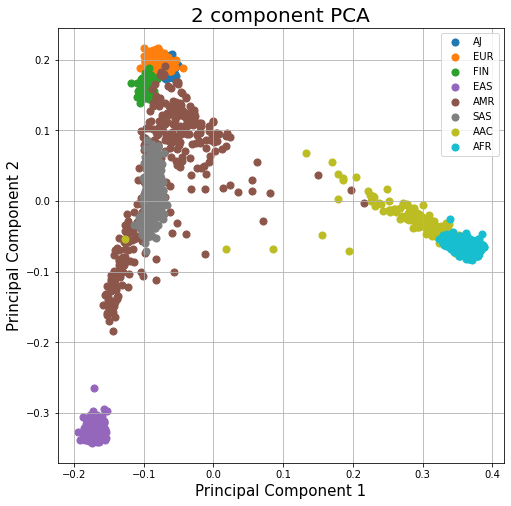

In [19]:
pruned_ref_fam = pd.read_csv(f'{ref_panel_prune_final}.fam', sep=' ', header=None)
total_pruned_ref_df = pruned_ref_fam.merge(ancestry_final, how='left', left_on=[0,1], right_on=['FID','IID'])
total_pruned_ref_df.label.value_counts()
total_pruned_ref_df

pca = pd.read_csv(f'{ref_panel_prune_final}.pcs', sep='\t')

# pca['FID'], pca['IID'] = pca['FID'].astype('str').str.lower(), pca['IID'].astype('str').str.lower()
# plate_labeled = plate.merge(combined_labels, how='left', on=['FID','IID'])

# combined_labels
labeled_pca = pca.merge(total_pruned_ref_df, how='left', on=['FID','IID'])
print(labeled_pca.label.value_counts())

def plot_pcs(labeled_pcs_df):
    # now plot PCs
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    cmap = cm.get_cmap('tab10')
    targets = list(labeled_pcs_df.label.unique())
    # targets = ['new', 'EUR']
    colors = cmap(np.linspace(0, 1, len(targets)))
    for target, color in zip(targets,colors):
        indicesToKeep = labeled_pcs_df['label'] == target
        ax.scatter(labeled_pcs_df.loc[indicesToKeep, 'PC1']
                   , labeled_pcs_df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    
plot_pcs(labeled_pca)

In [21]:
total_pruned_ref_df[total_pruned_ref_df[1] == 'RP1C2']

,0,1,2,3,4,5,FID,IID,label
419,AJ,RP1C2,0,0,2,1,AJ,RP1C2,AJ


In [12]:
# pruned_ref_fam = pd.read_csv(f'{ref_panel_prune_final}.fam', sep=' ', header=None)
# total_pruned_ref_df = pruned_ref_fam.merge(ancestry_final, how='left', left_on=[0,1], right_on=['FID','IID'])
# total_pruned_ref_df.label.value_counts()
# total_pruned_ref_df

,0,1,2,3,4,5,FID,IID,label
0,AJ,1A2,0,0,1,1,AJ,1A2,AJ
1,AJ,1A3,0,0,2,1,AJ,1A3,AJ
2,AJ,1A5,0,0,1,1,AJ,1A5,AJ
3,AJ,1A6,0,0,2,1,AJ,1A6,AJ
4,AJ,1A8,0,0,1,1,AJ,1A8,AJ
...,...,...,...,...,...,...,...,...,...
2970,NA21137,NA21137,0,0,0,-9,NA21137,NA21137,SAS
2971,NA21141,NA21141,0,0,0,-9,NA21141,NA21141,SAS
2972,NA21142,NA21142,0,0,0,-9,NA21142,NA21142,SAS
2973,NA21143,NA21143,0,0,0,-9,NA21143,NA21143,SAS


In [13]:
# pca_path = f'{ref_panel_10k_random_sample}_pca.eigenvec'
# pca = pd.read_csv(pca_path, sep=' ', header=None)
# pca_columns = ['FID','IID'] + [f"pc{i-1}" for i in range(2,len(pca.columns))]
# pca.columns = pca_columns

In [14]:
# # combined_labels
# labeled_pca = pca.merge(total_pruned_ref_df, how='left', on=['FID','IID'])
# print(labeled_pca.label.value_counts())

AFR    504
EAS    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64


In [32]:
# # now plot PCs
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# cmap = cm.get_cmap('tab10')
# targets = list(labeled_pca.label.unique())
# # targets = ['new', 'EUR']
# colors = cmap(np.linspace(0, 1, len(targets)))
# for target, color in zip(targets,colors):
#     indicesToKeep = labeled_pca['label'] == target
#     ax.scatter(labeled_pca.loc[indicesToKeep, 'pc1']
#                , labeled_pca.loc[indicesToKeep, 'pc2']
#                , c = color
#                , s = 50)
# ax.legend(targets)
# ax.grid()

# FastStructure test with Ref Panel

In [35]:
# Now, test with faststructure
ancestry_labels = f'{ref_dir_path}/ref_panel_ancestry.txt'
structure_out = f'{ref_panel_prune_final}'
fam = pd.read_csv(f'{ref_panel_prune_final}.fam', sep=' ', header=None)
structure = f'/data/vitaled2/ref_panel/fastStructure/structure.py'

In [40]:
# now run for k=1-8 and use chooseK.py to select best
with open(f'{ref_dir_path}/faststructure_choosek.swarm', 'w') as f:
    for k in range(1,9):
        fs_cmd = f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {ref_panel_prune_final} -o {structure_out} -f {structure} -k {k}'
        f.write(f'{fs_cmd}\n')
    f.close()

shell_do(f'swarm -f {ref_dir_path}/faststructure_choosek.swarm -g 16 --time=10:00:00 -t 20 --logdir {ref_dir_path}/swarm --partition=norm')
#         shell_do(f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {ref_panel_10k_random_sample} -o {structure_out} -f {structure} -k {k}')

In [39]:
choosek = '/data/vitaled2/ref_panel/fastStructure/chooseK.py'
print(f'bash /data/vitaled2/GWAS/gwas/faststructure_choosek_setup_and_run.sh -i {structure_out} -f {choosek}')

bash /data/vitaled2/GWAS/gwas/faststructure_choosek_setup_and_run.sh -i /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned -f /data/vitaled2/ref_panel/fastStructure/chooseK.py


In [42]:
# after fastStructure finishes running:
# read Q file and create labels
q_df = pd.read_csv(f'{structure_out}.8.meanQ', header=None, sep='\s+')
q_df.columns = [f'pop{i}' for i in range(1,9)]
fam['highest_2_pops'] = q_df.apply(lambda s: s.abs().nlargest(2).index.tolist(), axis=1)
fam['highest_pop'] = q_df.idxmax(axis=1)

q_df['FID'], q_df['IID'], q_df['highest_pop'], q_df['highest_2_pops'] = fam[0], fam[1], fam['highest_pop'], fam['highest_2_pops']


In [43]:
pop = pd.read_csv(ancestry_labels, sep='\t')
q_pop_merged = q_df.merge(pop, left_on=['FID','IID'], right_on=['FID','IID'])
print(q_pop_merged['highest_pop'].value_counts())
# q_pop_merged['label'].value_counts()
q_pop_merged.to_csv(f'{ref_dir_path}/labeled_faststructure.txt', sep='\t', header=True, index=False)


pop5    662
pop6    594
pop2    589
pop8    504
pop7    488
pop1    138
Name: highest_pop, dtype: int64


In [20]:
q_pop_merged.describe()
q_pop_merged['label'].unique()

array(['AJ', 'EUR', 'FIN', 'EAS', 'AMR', 'SAS', 'AAC', 'AFR'],
      dtype=object)

In [29]:
q_pop_merged[q_pop_merged['label'] == 'AJ'].describe() # almost 100% pop6
q_pop_merged[q_pop_merged['label'] == 'EUR'].describe() # 62% pop6 37% pop8
q_pop_merged[q_pop_merged['label'] == 'FIN'].describe() # almost 89% pop8
q_pop_merged[q_pop_merged['label'] == 'EAS'].describe() # almost 100% pop3
q_pop_merged[q_pop_merged['label'] == 'AMR'].describe() # 40% pop6 42% pop4, 10% pop8, 4% pop7
q_pop_merged[q_pop_merged['label'] == 'SAS'].describe() # 95% POP2
q_pop_merged[q_pop_merged['label'] == 'AAC'].describe() # almost 90% POP7
q_pop_merged[q_pop_merged['label'] == 'AFR'].describe() # almost 100% POP7

,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8
count,504.000000,5.040000e+02,504.000000,504.000000,504.000000,504.000000,5.040000e+02,504.000000
mean,0.000098,6.000000e-06,0.000619,0.000351,0.000287,0.000323,6.000000e-06,0.998307
std,0.001511,1.695749e-21,0.003803,0.002969,0.003094,0.003524,1.695749e-21,0.006746
min,0.000006,6.000000e-06,0.000006,0.000006,0.000006,0.000006,6.000000e-06,0.936400
25%,0.000006,6.000000e-06,0.000006,0.000006,0.000006,0.000006,6.000000e-06,0.999956
50%,0.000006,6.000000e-06,0.000006,0.000006,0.000006,0.000006,6.000000e-06,0.999956
75%,0.000006,6.000000e-06,0.000006,0.000006,0.000006,0.000006,6.000000e-06,0.999956
max,0.029150,6.000000e-06,0.041838,0.035115,0.047596,0.063563,6.000000e-06,0.999956


# 

In [ ]:
#distruct run for visualization
distruct_run = f'python /data/vitaled2/ref_panel/fastStructure/distruct.py\
 -K 8\
 --input={ref_panel_final_prune}_final_structure\
 --output={ref_panel_final_prune}_distruct\
 --popfile={ref_dir_path}/faststructure_labels.txt\
 --title="GP2 Reference Panel Ancestries"'

print(distruct_run)
